In [6]:
try:
  %tensordlow_ersion 2.x

except:
  pass

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os

from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow

print("\u2024 Using TensorFlow Version:", tf.__version__)
print(
    "\u2024 GPU Device Found."
    if tf.test.is_gpu_available()
    else "\u2024 GPU Device Not Found. Running on CPU"
)

․ Using TensorFlow Version: 2.15.0
․ GPU Device Found.


In [5]:
import zipfile

zip_path = '/content/archive_dataset_tomat.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [9]:
dataset_dir=r'/content/data/train'


filepaths=[]
labels=[]
classlist=os.listdir(dataset_dir)

for classs in classlist:
    classpath=os.path.join(dataset_dir,classs)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(classs)

file_series= pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)

print (df['labels'].value_counts())


yellow_leaf_curl_virus    3595
early_blight              2177
late_blight               2093
healthy                   1883
bacterial_spot            1679
leaf_mold                 1460
septoria_leaf_spot        1327
twospotted_spider_mite    1232
mosaic_virus              1197
target_spot               1110
Name: labels, dtype: int64


In [10]:
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)
train_dataframe, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_dataframe, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train data frame len: ', len(train_dataframe), '  test data frame len: ', len(test_dataframe), '  valid data frame len: ', len(valid_df))


train data frame len:  14202   test data frame len:  1775   valid data frame len:  1776


In [11]:
# Set image dimensions and batch size
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Calculate test batch size and steps
length = len(test_dataframe)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)


test batch size: 71   test steps: 25


In [12]:
# Create ImageDataGenerators
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = gen.flow_from_dataframe(
    train_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,

)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = gen.flow_from_dataframe(
    test_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 14202 validated image filenames belonging to 10 classes.
Found 1776 validated image filenames belonging to 10 classes.
Found 1775 validated image filenames belonging to 10 classes.


In [13]:
# Get class labels
classes = list(train_gen.class_indices.keys())
print(classes)
# print class
class_indices = train_gen.class_indices
class_count = len(classes)
print("Number of classes: ",class_indices)


['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'mosaic_virus', 'septoria_leaf_spot', 'target_spot', 'twospotted_spider_mite', 'yellow_leaf_curl_virus']
Number of classes:  {'bacterial_spot': 0, 'early_blight': 1, 'healthy': 2, 'late_blight': 3, 'leaf_mold': 4, 'mosaic_virus': 5, 'septoria_leaf_spot': 6, 'target_spot': 7, 'twospotted_spider_mite': 8, 'yellow_leaf_curl_virus': 9}


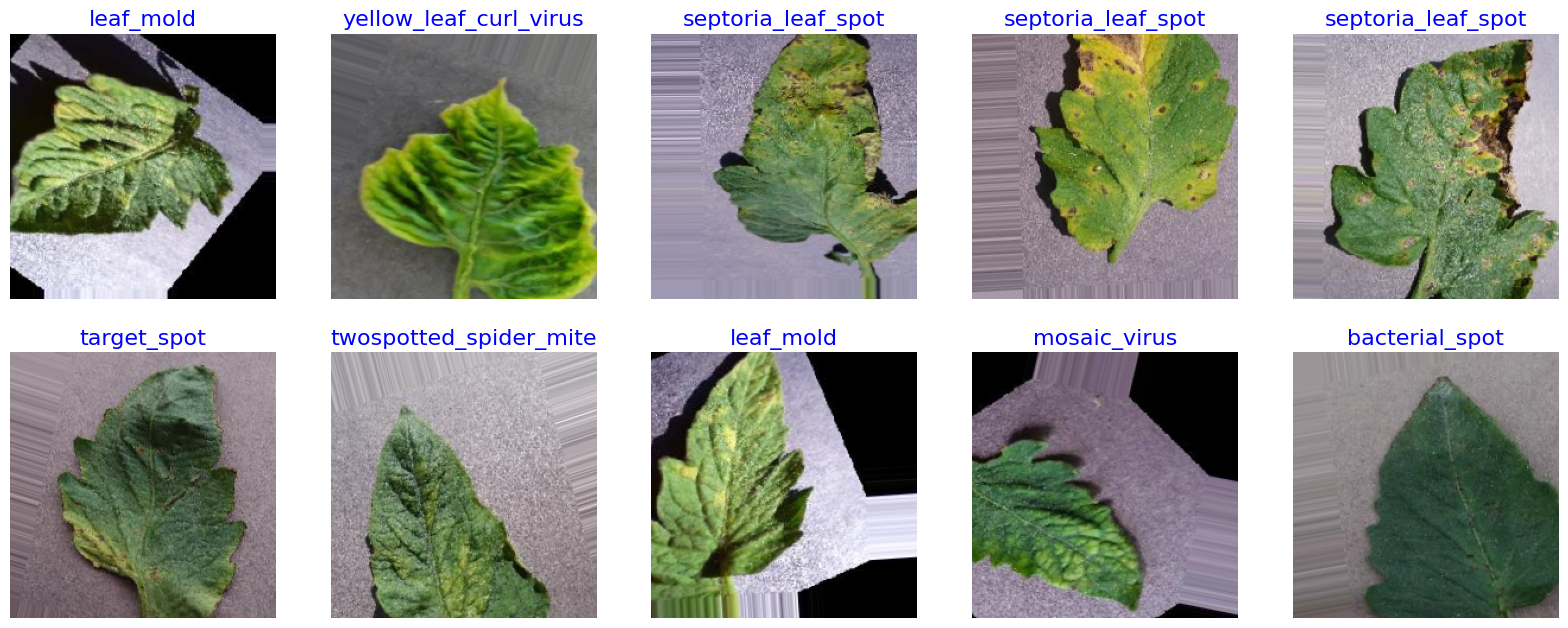

In [14]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 10:
        r = length
    else:
        r = 10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

# Example usage
show_image_samples(test_gen)


In [15]:
height = 224
width = 224
channels = 3

# Transfer Learning MobileNetV2
TL_model = tf.keras.applications.MobileNetV2(
    input_shape=(height, width, channels),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=(height, width, channels)),
    pooling=None,
)


In [16]:
TL_model.trainable = False


In [17]:
model_name = 'tirta voyaguers'
print("Building model with", TL_model)
model = tf.keras.Sequential([
    TL_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Building model with <keras.src.engine.functional.Functional object at 0x7a24f1367010>


In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2423242 (9.24 MB)
Trainable params: 165258

In [19]:
import matplotlib.pyplot as plt

# Latih model dengan callback EarlyStopping
history = model.fit_generator(generator=train_gen, epochs=20, validation_data=valid_gen)


<ipython-input-19-8bb17b555153>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen, epochs=20, validation_data=valid_gen)


Epoch 1/20
222/222 [==============================] - 199s 860ms/step - loss: 1.1256 - accuracy: 0.6163 - val_loss: 0.5949 - val_accuracy: 0.8046
Epoch 2/20
222/222 [==============================] - 186s 839ms/step - loss: 0.7119 - accuracy: 0.7574 - val_loss: 0.4922 - val_accuracy: 0.8316
Epoch 3/20
222/222 [==============================] - 185s 832ms/step - loss: 0.6193 - accuracy: 0.7848 - val_loss: 0.4261 - val_accuracy: 0.8581
Epoch 4/20
222/222 [==============================] - 185s 835ms/step - loss: 0.5623 - accuracy: 0.8093 - val_loss: 0.3797 - val_accuracy: 0.8750
Epoch 5/20
222/222 [==============================] - 185s 834ms/step - loss: 0.5380 - accuracy: 0.8154 - val_loss: 0.3884 - val_accuracy: 0.8643
Epoch 6/20
222/222 [==============================] - 186s 838ms/step - loss: 0.5169 - accuracy: 0.8219 - val_loss: 0.3616 - val_accuracy: 0.8761
Epoch 7/20
222/222 [==============================] - 188s 846ms/step - loss: 0.4938 - accuracy: 0.8285 - val_loss: 0.3683 -

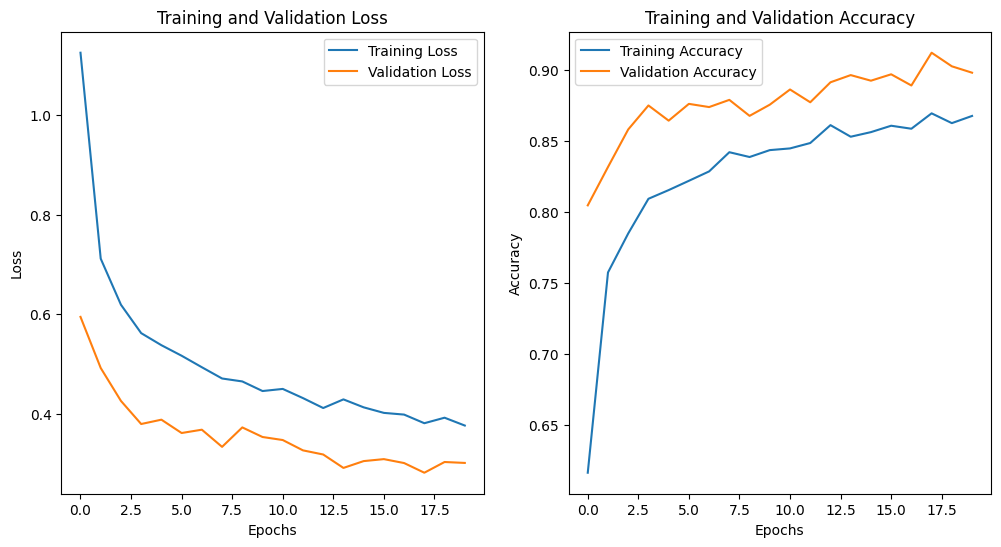

In [20]:
import matplotlib.pyplot as plt

# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [21]:
TIRTA_VOYAGUERS_SAVED_MODEL = "tirta_voyaguers_saved_model"

In [22]:
tf.saved_model.save(model, TIRTA_VOYAGUERS_SAVED_MODEL)

In [23]:
%%bash -s $TIRTA_VOYAGUERS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default


The given SavedModel SignatureDef contains the following input(s):
  inputs['mobilenetv2_1.00_224_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_mobilenetv2_1.00_224_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-05-07 08:03:55.787820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 08:03:55.787874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 08:03:55.789429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 08:03:56.789769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
loaded = tf.saved_model.load(TIRTA_VOYAGUERS_SAVED_MODEL)

In [26]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'mobilenetv2_1_00_224_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='mobilenetv2_1.00_224_input')})
{'dense_1': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_1')}


In [35]:
import tensorflow as tf

# Load the SavedModel
loaded_model = tf.saved_model.load('/content/tirta_voyaguers_saved_model/')

# Akses signature 'serving_default'
inference = loaded_model.signatures['serving_default']

# Contoh menjalankan inferensi dengan input yang sesuai
# Misalnya, kita punya gambar dengan dimensi 224x224x3
# Anda dapat menyesuaikan ini dengan input yang Anda miliki
input_image = tf.random.normal([1, 224, 224, 3])  # Contoh input gambar dengan dimensi yang sesuai

# Jalankan inferensi dengan input gambar
output = inference(input_image)

print(output)  # Print output dari inferensi


{'dense_1': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.9368186e-09, 7.6855085e-04, 9.9723047e-01, 8.6672656e-04,
        3.7875015e-08, 7.9777310e-06, 1.4584503e-04, 9.7835588e-04,
        1.9412678e-06, 3.0274453e-08]], dtype=float32)>}


In [37]:

# Load the SavedModel
loaded_model = tf.saved_model.load('/content/tirta_voyaguers_saved_model/')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/tirta_voyaguers_saved_model/')
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('/content/tirta_voyaguers_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [44]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/tirta_voyaguers_model.tflite")
interpreter.allocate_tensors()

# Get input and output from tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output data
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[2.3131201e-09 5.1858010e-06 9.9783355e-01 2.0557207e-03 6.6334832e-07
  5.3247045e-06 9.8323129e-05 9.9029387e-07 1.2952717e-07 1.5881035e-09]]


In [45]:
import shutil
shutil.make_archive("tirta_voyaguers_saved_model", "zip", "tirta_voyaguers_saved_model")


'/content/tirta_voyaguers_saved_model.zip'

In [46]:
model.save('model_tirta_voyaguers.h5')


In [50]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

# Mapping kelas
class_mapping = {'bacterial_spot': 0, 'early_blight': 1, 'healthy': 2, 'late_blight': 3, 'leaf_mold': 4, 'mosaic_virus': 5, 'septoria_leaf_spot': 6, 'target_spot': 7, 'twospotted_spider_mite': 8, 'yellow_leaf_curl_virus': 9}

# Fungsi untuk memprediksi gambar
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_class_index)]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

# Load model
model = tf.keras.models.load_model('/content/model_tirta_voyaguers.h5')

# Contoh pengujian dengan gambar
image_path = '/content/data/test/septoria_leaf_spot/img_sls_1.jpg'
predicted_class, confidence = predict_image(model, image_path)

# Output hasil prediksi
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 1s 805ms/step
Predicted Class: septoria_leaf_spot
Confidence: 0.8133973
